# Genetic Algorithm

GA is a simple optimisation algorithm that mimics evolution. It starts with a random population of elements, and evaluates how <i>fit for survival</i> they are. Elements are then randomly selected in pairs to mate and produce a new generation of offspring. The selection ensures that elements with higher fitness are more likely to be chosen for mating, thus increasing the chances that their offspring retains the characteristics that made their parents fit in the first place. Random mutation can also appear.

If an optimisation problem is too complex to be solved via gradient methods, GA can still give an answer.

In this tutorial we are going to use GA to find a set of parameters that fit a signal.<br>
More details about the GA are given in the following sections.

In [15]:
#resolve GA dependency
import os
import os.path
if os.path.exists('GA.py'):
    pass
else:
    !wget https://raw.githubusercontent.com/reinimaurer1/ML-CSC-tutorial/master/GA.py
    !wget https://github.com/reinimaurer1/ML-CSC-tutorial/raw/master/data/ga-train-Y.npy
    !wget https://github.com/reinimaurer1/ML-CSC-tutorial/raw/master/data/ga-train-T.npy
# IMPORTS

import math
import random
import numpy
from GA import GAEngine
import matplotlib.pyplot as plt

--2021-08-04 08:27:13--  https://raw.githubusercontent.com/reinimaurer1/ML-CSC-tutorial/master/GA.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3095 (3.0K) [text/plain]
Saving to: ‘GA.py’

GA.py               100%[===================>]   3.02K  --.-KB/s    in 0s      

2021-08-04 08:27:13 (37.7 MB/s) - ‘GA.py’ saved [3095/3095]

--2021-08-04 08:27:13--  https://github.com/reinimaurer1/ML-CSC-tutorial/raw/master/data/ga-train-Y.npy
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/reinimaurer1/ML-CSC-tutorial/master/data/ga-train-Y.npy [following]
--2021-08-04 08:27:13--  https://raw.githubuse

## Definition of the problem
We are given an compound oscillatory signal $W(t)$ at given times and we would like to find its components. We are too primitive to use FFT or non-linear fitting. We are dumb and strong, so we brute-force it!

## Definition of element

Each $i$-th element of the genetic population represents a possible candidate signal $W_i(t) = \sum_{k=1}^n A_k \cos\left( 2\pi k t\right)$. Thus, the element can be represented by the list of amplitudes for each wave component: $\mathbf{e} = \{ A_1, A_2, ... A_n\}$.

The training set is a collection of $\left( t,W(t) \right)$ points corresponding to the signal we are trying to fit.

[[ 1.33564592  0.73001431  0.33759851 -1.25772932 -1.0279217 ]
 [ 1.32937874  1.9328393  -0.12190019 -0.83787276 -0.90917771]
 [-1.26419402 -1.36507861  0.67696366 -1.75331188  0.26288343]]


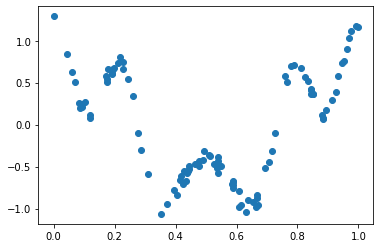

In [16]:
# set a decent population size to work with
populationSize = 100

# set the amount of plane waves
nWaves = 5

# limit amplitudes to [-2, 2]
scale = 2.0

# create a GA engine
ga = GAEngine(popSize=populationSize, dnaSize=nWaves, scale=scale)

ga.tau = 0.1

# print the first 3 elements to see what we are dealing with!
print(ga.population[0:3])

# load a training set
trainT = numpy.load("ga-train-T.npy") # time values
trainY = numpy.load("ga-train-Y.npy") # corresponding signal values

# plot the training set
plt.plot(trainT, trainY, 'o')
plt.show()

##### Mixing elements

After the population is evaluated, all elements are sorted by descending fitness (best fit first). Pairs of elements are selected at random by their index, using an exponential distribution, and mixed to produce an offspring population.
The simplest mixing function would be the one that assign each DNA component of the offspring from either parent at 
random. This function is already defined in the GAEngine.

We can control the PDF for the selection using one parameter:

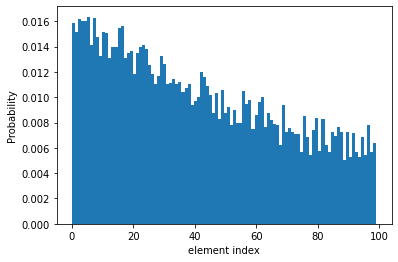

In [17]:
ga.tau = 1
selected = ga.TrySelection(10000)
plt.hist(selected, populationSize, density=True)
plt.xlabel('element index')
plt.ylabel('Probability')
plt.show()

Large values of $\tau$ will cause elements with low fitness to be almost never selected. This will make the GA "converge" faster, halting evolution.

Small values of $\tau$ will eventually give equal chance to all elements regardless of their fitness. This will slow down the evolution.

You will have to find a good compromise!

##### Mutating elements

Occasionally, mutation can appear when mixing two elements. There are several ways to implement mutations, but here we stick to simplicity. A mutation adds a random value to one random gene of the element. <br>
Mutations should be rare or they will mess up the evolution!

In [18]:
# set the mutation rate
ga.mutationRate = 0.01 # this means 1% of the elements will get it

##### Evaluating fitness

This function takes in the element descriptor, performs the calculations necessary to estimate how well it performs, and returns its fitness.<br>
It is actually easy to calculate its badness (mean square error) and flip the sign. This way, the perfect element will have 0 fitness, while any mismatch with the training will give a negative value.

In [19]:
def EvaluateFitness(element):

    # prepare a 0 array
    y = numpy.zeros(len(trainT))
    freq = 1 # starting frequency
    
    for amp in element: # loop through the amplitudes
        y += amp * numpy.cos(2*numpy.pi*freq*trainT) # add the wave
        freq += 1 # increment the frequency for the next wave
    
    # compute square error
    y = (y-trainY)*(y-trainY)
    
    return -numpy.mean(y)

# tell the engine to use this evaluation function
ga.Evaluate = EvaluateFitness

##### Evolving...

Let the population evolve!

In [20]:
# number of generations to compute
nGens = 30

stats = numpy.zeros((nGens,3))

# start the evolution loop!
for g in range(nGens):
    stats[g] = ga.Evolve()

generation[0] fitness: best -0.4832648419812755, avg -3.691163359965617, worse -8.682922705215653
generation[1] fitness: best -0.979780288690028, avg -3.4953588755636615, worse -8.37493468274089
generation[2] fitness: best -0.524063162141791, avg -3.089050872796814, worse -7.54186852161268
generation[3] fitness: best -0.645728212223134, avg -2.642379691328993, worse -6.567404206733342
generation[4] fitness: best -0.1457884210001886, avg -2.0583539026922604, worse -5.993865136694937
generation[5] fitness: best -0.33909607616890974, avg -1.8469642862179134, worse -5.208754167180582
generation[6] fitness: best -0.23796937247169161, avg -1.588899458678205, worse -4.930657035647892
generation[7] fitness: best -0.19113847640756043, avg -1.293257108885668, worse -4.251652919215783
generation[8] fitness: best -0.06765846387367161, avg -1.1221324298310549, worse -3.350104434231788
generation[9] fitness: best -0.12152615422796945, avg -1.0007795829762012, worse -2.743459996931745
generation[10] 

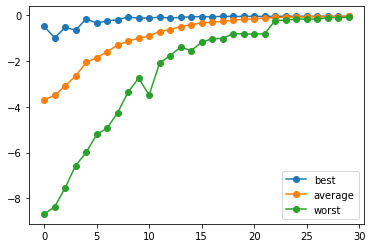

In [21]:
# evolution plot
plt.plot(stats[:,0],'o-', label='best')
plt.plot(stats[:,1],'o-', label='average')
plt.plot(stats[:,2],'o-', label='worst')
plt.legend()
plt.show()

best model amplitudes: [ 0.84438943 -0.08743837 -0.00865067  0.47168171  0.32568701]
best model fitness: -0.03602259071066929


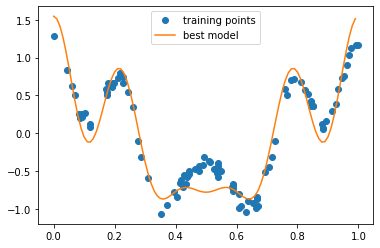

In [22]:
# best element info
print("best model amplitudes:", ga.best)
print("best model fitness:", ga.bestFit)
t = numpy.arange(0,1,0.01)
y = t * 0
freq = 1 # starting frequency

for amp in ga.best: # loop through the amplitudes
    y += amp * numpy.cos(2*numpy.pi*freq*t) # add the wave
    freq += 1 # increment the frequency for the next wave
        
plt.plot(trainT, trainY, 'o', label='training points')
plt.plot(t, y, '-', label='best model')
plt.legend()
plt.show()


##### Final remarks
Do not be fooled by the speed of this example... in real applications, training an AI with GA can take up to several weeks on supercomputers.<br>
You can see one in action <a href="http://www.nanolayers.com/nano_copter.php">here!</a> Try to beat it!

## Beast Exercise

Train neural networks to output the energy of a molecule using ACSFs as input. 
There should be one network for each atom type and ACSF contribution. For example, all H atoms will have 5 NNs that process the ACSFs calculated for that atom with respect to C, N, O, or F atoms.
Additionally there will be NNs for the 3-body parts: H-HH, H-HC, H-HN, ... total 15 NNs
In total, each atom type should have 5 + 15 = 20 NNs, giving a total of 100 NNs and lots of parameters to train!

Some serious python hacking is required!


In [ ]:
# load structures and energies from the database
# the file is data/structures.xyz and it contains lots of molecules in the following xyz format:
# 
# natoms_mol1
# energy_mol1
# type1 x y z
# type2 x y z
# ...
# natoms_mol2
# energy_mol2
# type1 x y z
# ...
#

In [ ]:
# use DScribe to compute ACSFs
# ...

# the ACSFs should be divided into their logical contributions (x-H, x-C, ... x-HH, x-HC, ...)
# the length of each contribution 

In [ ]:
from sklearn.neural_network import MLPRegressor

# setup model networks for all possible atoms
# there are only H, C, N, O, F atoms in the database
#
# H -> H (2-body)
# H -> C (2-body)
# ...
# H -> H-H (3-body)
# H -> H-C (3-body) (no need for H -> C-H, it is symmetric!)
# ...

In [ ]:
# sklearn network weights and neuron biases are stored in
# model.coefs_ and model.intercepts_
# these are assigned only after calling model.fit(x, y), does not matter if the training succeeded
# as long as x,y have the correct shape
#
# the GA DNA is the concatenation of all these numbers
# 
# calculate the total length of the DNA
# ...

# write a function that converts the DNA (list of numbers) into a set of model.coefs_ and 
# model.intercepts_ for a sklearn model
# ...

# write an evaluation function for the fitness of a GA element
# ...

# evolve the population
# ...